# Aplicación Práctica: Predicción de Ingresos con Regresión Lasso

<a href="https://colab.research.google.com/github/josuecaldas/predict_income/blob/main/PYTHON_predict_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo:** Este cuaderno demuestra el uso de la Regresión Lasso para predecir el ingreso monetario y, fundamentalmente, para seleccionar las variables más relevantes de un conjunto de datos de alta dimensionalidad.

**Contexto de Investigación:** Utilizamos datos de la Encuesta Nacional de Hogares (ENAHO) 2020 para Lima Metropolitana. Nos enfrentamos a un problema común en las ciencias sociales: disponemos de una gran cantidad de predictores (144 en este caso) y sospechamos que solo un subconjunto de ellos es verdaderamente influyente.

**Metodología:** La Regresión Lasso es ideal para este escenario, ya que su capacidad de penalización puede reducir los coeficientes de las variables menos importantes a exactamente cero, realizando así una selección de variables automática.

### 1. Configuración del Entorno

En esta sección, importamos todas las librerías necesarias para el análisis. Utilizamos `pandas` para la manipulación de datos, `numpy` para operaciones numéricas y `scikit-learn` para el modelado y la evaluación.

In [ ]:
#pip install pandas numpy seaborn matplotlib scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------------------------- -------- 8.7/11.0 MB 43.5 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 37.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------------------- - 7.9/8.1 MB 43.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 38.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 37.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 7.0/7.0 MB 51.7 MB/s eta 0:00:00

   ----------------------------------------  0/11 [pytz]
   ----------------------------------------  0/11 [pytz]
   ----------------------------------------  0/11 [pytz]
   --- ------------------------------------  1/11 [tzdata]
   --- --------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [12]:
# Librerías para manipulación y análisis de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Clases y funciones de Scikit-Learn para el modelado
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# Configuración para mejorar la visualización
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 2. Carga y Exploración Inicial de los Datos (EDA)

Cargamos el conjunto de datos y realizamos una exploración inicial para entender su estructura y la variable que deseamos predecir.

In [13]:
# Carga de la base de datos desde el archivo CSV
data = pd.read_csv("predict_income_2020.csv", encoding = "latin-1")

# Eliminamos la columna 'Unnamed: 0' que parece ser un índice residual del archivo
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)

# Mostramos las primeras filas para verificar la carga
data.head()

,p207_20,p208a_20,p104_20,p110a1_20,p1121_20,p1123_20,p1124_20,p1125_20,p1126_20,p1127_20,...,p401f_20_2,p401f_20_3,p558c_20_2,p558c_20_3,p558c_20_4,p558c_20_5,p558c_20_6,p558c_20_7,p558c_20_8,p558c_20_9
0,2,56,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,25,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,24,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2,52,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2,54,3,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Estadísticas Descriptivas del Ingreso (ingmo2hd):
count      7941.000000
mean      16417.901556
std       27288.599042
min           0.000000
25%         606.000000
50%        8427.000000
75%       20445.000000
max      382633.000000
Name: ingmo2hd, dtype: float64


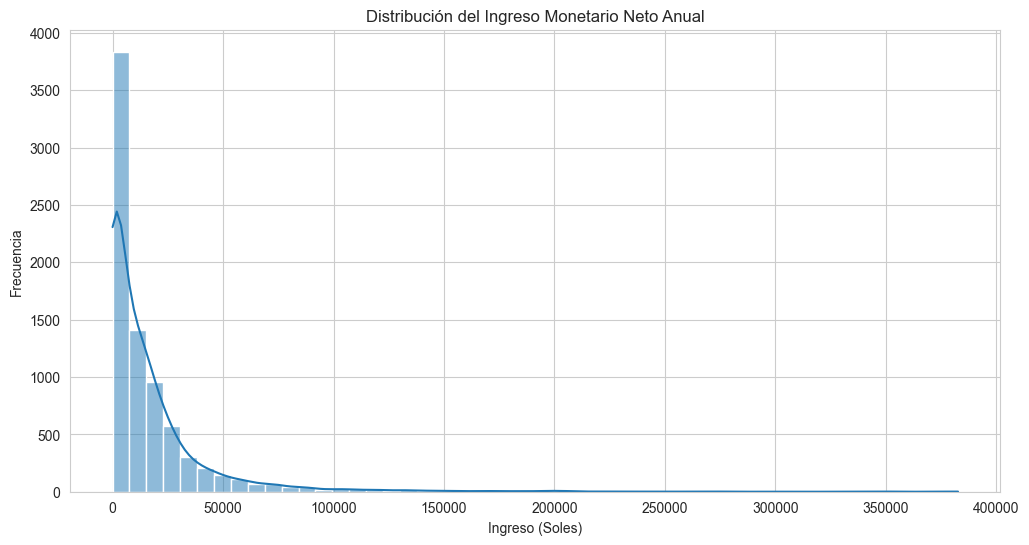

In [14]:


# Analizar la distribución de la variable objetivo (ingreso)
print("Estadísticas Descriptivas del Ingreso (ingmo2hd):")
print(data['ingmo2hd'].describe())

# Visualizar la distribución del ingreso
plt.figure(figsize=(12, 6))
sns.histplot(data['ingmo2hd'], kde=True, bins=50)
plt.title('Distribución del Ingreso Monetario Neto Anual')
plt.xlabel('Ingreso (Soles)')
plt.ylabel('Frecuencia')
plt.show()

### 3. Preparación para el Modelado

Aquí, separamos nuestros datos en:
1.  **Variable Predicha (y):** `ingmo2hd`.
2.  **Variables Predictoras (X):** Todas las demás variables.

Posteriormente, dividimos los datos en conjuntos de **entrenamiento (training)** y **prueba (test)**. Este es un paso crucial para evaluar el modelo de forma objetiva, probando su rendimiento en datos que no utilizó para aprender.

In [18]:
# 1. Separación de la variable predicha y los predictores
y = data['ingmo2hd']
X = data.drop('ingmo2hd', axis=1)

# 2. División en conjuntos de entrenamiento (70%) y prueba (30%)
# Usamos random_state para que la división sea reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

print(f"Dimensiones del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test): {X_test.shape}")

Dimensiones del conjunto de entrenamiento (X_train): (5558, 143)
Dimensiones del conjunto de prueba (X_test): (2383, 143)


### 4. Implementación y Entrenamiento del Modelo Lasso

Ahora procedemos a entrenar nuestro modelo. Utilizamos `LassoCV`, que no solo ajusta un modelo Lasso, sino que también utiliza **validación cruzada (Cross-Validation)** para encontrar el mejor hiperparámetro de penalización (`alpha`). Esto nos libera de tener que elegir un `alpha` manualmente y resulta en un modelo más robusto.

In [19]:
# Definimos el modelo Lasso con Validación Cruzada
# Se probarán 200 valores de alpha en un rango logarítmico
lasso_cv_model = LassoCV(alphas=np.logspace(-4, 4, 200), cv=5, random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
print("Entrenando el modelo LassoCV... (puede tardar unos momentos)")
lasso_cv_model.fit(X_train, y_train)
print("Entrenamiento completado.")

# Mostramos el mejor alpha encontrado por la validación cruzada
print(f"\nMejor alpha encontrado: {lasso_cv_model.alpha_:.4f}")

Entrenando el modelo LassoCV... (puede tardar unos momentos)
Entrenamiento completado.

Mejor alpha encontrado: 26.7384


### 5. Evaluación e Interpretación de Resultados

Con el modelo ya entrenado, evaluamos su desempeño en el **conjunto de prueba**, que contiene datos que el modelo nunca antes ha visto. Esto nos da una medida honesta de su capacidad de generalización.

In [20]:
# Realizar predicciones sobre el conjunto de prueba
y_pred_lasso = lasso_cv_model.predict(X_test)

# Calcular métricas de error
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Raíz del Error Cuadrático Medio (RMSE) en el conjunto de prueba: {rmse_lasso:.2f}")
print(f"Coeficiente de Determinación (R²) en el conjunto de prueba: {r2_lasso:.4f}")

Raíz del Error Cuadrático Medio (RMSE) en el conjunto de prueba: 22764.85
Coeficiente de Determinación (R²) en el conjunto de prueba: 0.3831


#### Interpretación de las Métricas

*   **RMSE (Root Mean Squared Error):** Nos indica que, en promedio, el error de predicción de nuestro modelo es de aproximadamente [inserta el valor de RMSE] soles.
*   **R² (Coeficiente de Determinación):** El valor de [inserta el valor de R²] nos dice que nuestro modelo es capaz de explicar aproximadamente el [inserta el R² en porcentaje]% de la variabilidad del ingreso en el conjunto de prueba. Para datos socioeconómicos, este es un resultado sólido e informativo.

#### Análisis de Coeficientes: El Poder de la Selección de Variables

El resultado más importante de Lasso para las ciencias sociales es la **interpretación de los coeficientes**. El modelo ha reducido a cero muchas de las variables originales, permitiéndonos enfocar en las que tienen un impacto real.

In [21]:
# Crear un DataFrame con los predictores y sus coeficientes
coeficientes_lasso = pd.DataFrame({
    'predictor': X.columns,
    'coef': lasso_cv_model.coef_
})

# Filtrar los coeficientes que no son cero
coeficientes_seleccionados = coeficientes_lasso[coeficientes_lasso['coef'] != 0].sort_values(by='coef', ascending=False)

print(f"De {len(coeficientes_lasso)} predictores iniciales, Lasso seleccionó {len(coeficientes_seleccionados)}.")
print("\nPredictores más importantes seleccionados por el modelo Lasso:")
print(coeficientes_seleccionados)

De 143 predictores iniciales, Lasso seleccionó 65.

Predictores más importantes seleccionados por el modelo Lasso:
       predictor          coef
131  p301a_20_11  33577.394545
41   p558e1_1_20  10717.650700
42   p558e1_2_20   9356.739404
130  p301a_20_10   8699.013386
39     p558a4_20   4065.220532
43   p558e1_3_20   2399.941481
71     p101_20_2   2226.045855
30     p5564a_20   1789.890222
21   p314b1_2_20   1610.944341
45   p558e1_7_20   1595.854592
20   p314b1_1_20   1514.623329
133   p401f_20_2   1468.176534
44   p558e1_6_20   1443.763446
79     p102_20_7   1172.917277
127   p301a_20_7   1093.539788
22   p314b1_6_20    984.115095
59      p4022_20    786.790120
17       p306_20    722.396783
2        p104_20    695.220454
82    p105a_20_2    626.174712
84    p105a_20_4    504.878108
12      p1143_20    399.752733
15      p301b_20    338.547497
100   p113a_20_2    327.747199
107    p209_20_2    262.902319
23   p314b1_7_20    165.674671
1       p208a_20    139.023393
139   p558c_20_6 

C:\Users\zadel\AppData\Local\Temp\ipykernel_6484\2474106296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='predictor', data=coeficientes_seleccionados, palette='viridis')


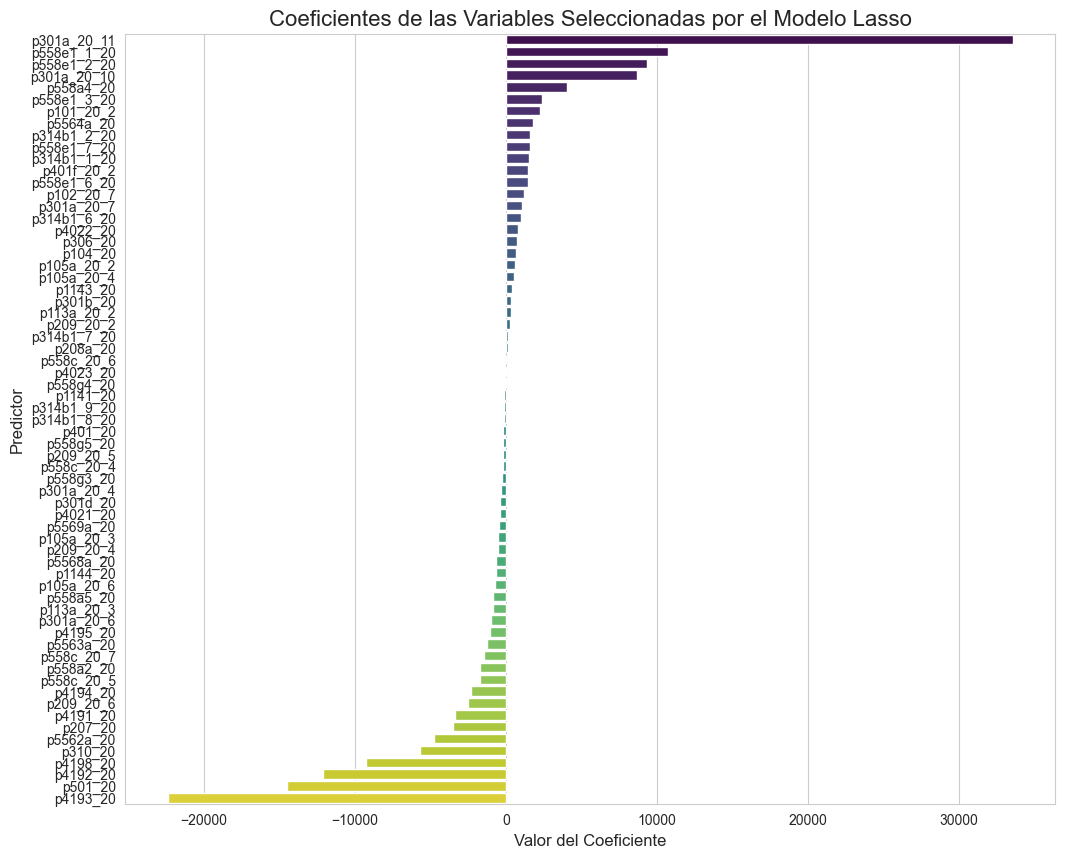

In [22]:
# Visualizar los coeficientes más importantes
plt.figure(figsize=(12, 10))
sns.barplot(x='coef', y='predictor', data=coeficientes_seleccionados, palette='viridis')
plt.title('Coeficientes de las Variables Seleccionadas por el Modelo Lasso', fontsize=16)
plt.xlabel('Valor del Coeficiente', fontsize=12)
plt.ylabel('Predictor', fontsize=12)
plt.show()

### 6. Conclusión

Este análisis práctico ha demostrado el valor de la Regresión Lasso en un contexto de investigación social. No solo hemos construido un modelo con un poder predictivo razonable (R² ≈ 0.50), sino que, más importante aún, hemos utilizado la capacidad del modelo para **reducir la complejidad y seleccionar automáticamente los predictores más relevantes** de un conjunto de 144 variables.

La visualización de los coeficientes nos proporciona una guía clara sobre qué factores tienen una mayor asociación con el ingreso, permitiendo al investigador enfocar sus esfuerzos de interpretación y construcción teórica en un conjunto de variables manejable y empíricamente validado.